In [1]:
import numpy as np

### Osservazione
Abbiamo smarronato, i punti non sono uguali e sono traslati male rispetto alle correnti, quindi per BPOS dobbiamo ogni volta togliere il valore iniziale (per cui $i_{genB} = 1.3A$) e per BNEG anche dobbiamo rimuovere il punto iniziale, per cui $i_{genB} = 0.1A$. 

In [2]:
import uproot
import uproot3

import awkward as ak
import awkward0

import ROOT as root


import matplotlib as mpl
import matplotlib.pyplot as plt

from uncertainties import ufloat
import setup_hall.linear_regression as lg

import pandas as pd

up4_data0 = uproot.open('../dati/dataRUN_20220524_09.57.00.902015_HALL.root')
up4_data0.keys()

BPOS = up4_data0['data_BPOS']
BNEG = up4_data0['data_BNEG']

BPOS, BNEG

Welcome to JupyROOT 6.24/02


(<TTree 'data_BPOS' (7 branches) at 0x00013cdd4e80>,
 <TTree 'data_BNEG' (7 branches) at 0x00012c658eb0>)

In [3]:


ak_BPOS = BPOS.arrays()
ak_BNEG = BNEG.arrays()

print(ak.to_pandas(ak_BPOS))

ak_BPOS, ak_BNEG

                ID  RUN  BUFSIZE  V_gen_lo  V_gen_hi  V_out_lo  V_out_hi
entry subentry                                                          
0     0          1    1      100       0.0       5.0       0.0  0.366569
      1          1    1      100       0.0       5.0       0.0  0.376344
      2          1    1      100       0.0       5.0       0.0  0.366569
      3          1    1      100       0.0       5.0       0.0  0.376344
      4          1    1      100       0.0       5.0       0.0  0.371457
...             ..  ...      ...       ...       ...       ...       ...
11    95         1   12      100       0.0       5.0       0.0  0.322581
      96         1   12      100       0.0       5.0       0.0  0.327468
      97         1   12      100       0.0       5.0       0.0  0.322581
      98         1   12      100       0.0       5.0       0.0  0.312805
      99         1   12      100       0.0       5.0       0.0  0.322581

[1200 rows x 7 columns]


(<Array [{ID: 1, RUN: 1, ... 0.323]}] type='12 * {"ID": uint32, "RUN": uint32, "B...'>,
 <Array [{ID: 1, RUN: 1, ... 0.269]}] type='12 * {"ID": uint32, "RUN": uint32, "B...'>)

In [4]:
v_gen = (ak_BPOS.V_gen_hi-ak_BPOS.V_gen_lo).to_numpy().mean(axis=1)
v_gen_std = (ak_BPOS.V_gen_hi-ak_BPOS.V_gen_lo).to_numpy().std(axis=1)

v_gen, v_gen_std

(array([4.99887586, 4.99902248, 4.99892473, 4.99872923, 4.9987781 ,
        4.99931574, 4.99916911, 4.99887586, 4.9987781 , 4.99907136,
        4.99892473, 4.99872923]),
 array([0.00275228, 0.00267704, 0.0024516 , 0.00281789, 0.00262067,
        0.00195747, 0.0022982 , 0.00275228, 0.00304249, 0.0021522 ,
        0.00254718, 0.00290143]))

In [5]:
%jsroot on
v_gen_u = ufloat(ak.concatenate((ak_BPOS.V_gen_hi-ak_BPOS.V_gen_lo, ak_BNEG.V_gen_hi-ak_BNEG.V_gen_lo)).to_numpy().mean(), 
                 ak.concatenate((ak_BPOS.V_gen_hi-ak_BPOS.V_gen_lo, ak_BNEG.V_gen_hi-ak_BNEG.V_gen_lo)).to_numpy().std())
print('v_gen_u = {:.3u}, ({:.3} ppt)'.format(v_gen_u, (v_gen_u.s/v_gen_u.n)*1000))

i10mA = lg.linear_regression('generatore.txt', system='current')
i10mA.set_model_parameters(1000/500, 0)
p0,p1 = i10mA.fit_model()

gain_gen = ufloat(p0[0], p0[1])/1000
print('gain_gen = {:.3u}, ({:.3} ppt)'.format(gain_gen, (gain_gen.s/gain_gen.n)*1000))

current_i10mA = v_gen_u*gain_gen
print('current_i10mA = {:.3u}, ({:.3} ppt)'.format(current_i10mA, (current_i10mA.s/current_i10mA.n)*1000))


v_gen_u = 4.99897+/-0.00256, (0.512 ppt)
model results chi2/ndf (prob): 0.2796881563157294/9 (0.9999975624782381)
correlation parameter: 1.7242(300) [arb. u.]
offset: 0.0673(889) [coherent units with y-axis value]
gain_gen = 0.0017242+/-0.0000300, (17.4 ppt)
current_i10mA = 0.008619+/-0.000150, (17.4 ppt)
Applying ATLAS style settings
 FCN=0.279688 FROM MIGRAD    STATUS=CONVERGED      50 CALLS          51 TOTAL
                     EDM=7.59718e-13    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.72418e+00   3.00379e-02   8.48703e-06  -6.62704e-05
   2  p1           6.73130e-02   8.89182e-02   2.51236e-05  -1.14248e-05


In [6]:
## caratterizzazione OPAMP strum


g_diff = lg.linear_regression(filename='guadagnoDIFF.txt', system='keithley')
g_diff.set_model_parameters(200, 0)

p0,p1 = g_diff.fit_model()

gain_vh = ufloat(p0[0], p0[1])
print('gain_vh = {:.3u}, ({:.3} ppt)'.format(gain_vh, (gain_vh.s/gain_vh.n)*1000))

model results chi2/ndf (prob): 0.27104059485739196/3 (0.9653796521342823)
correlation parameter: 206.6(24.5) [arb. u.]
offset: -1.495(866) [coherent units with y-axis value]
gain_vh = 206.6+/-24.5, (1.18e+02 ppt)
Applying ATLAS style settings
 FCN=0.271041 FROM MIGRAD    STATUS=CONVERGED      53 CALLS          54 TOTAL
                     EDM=4.59676e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           2.06551e+02   2.44501e+01   2.63094e-03  -6.14426e-05
   2  p1          -1.49456e+00   8.66213e-01   9.32122e-05  -1.78704e-03


Warning in <TCanvas::Constructor>: Deleting canvas with same name: __figure__


In [7]:
v_bpos     = (ak_BPOS.V_out_hi-ak_BPOS.V_out_lo).to_numpy()[1:,:].mean(axis=1)
v_bpos_std = (ak_BPOS.V_out_hi-ak_BPOS.V_out_lo).to_numpy()[1:,:].std(axis=1)

print(v_bpos, v_bpos_std, np.shape(v_bpos), np.shape(v_bpos_std))

v_bneg     = (ak_BNEG.V_out_hi-ak_BNEG.V_out_lo).to_numpy()[1:,:].mean(axis=1)
v_bneg_std = (ak_BNEG.V_out_hi-ak_BNEG.V_out_lo).to_numpy()[1:,:].std(axis=1)

print(v_bneg, v_bneg_std, np.shape(v_bneg), np.shape(v_bneg_std))

[0.3682307  0.36344087 0.35826002 0.35312805 0.34833822 0.34447703
 0.33866081 0.33416423 0.33000977 0.3252688  0.32057672] [0.0034017  0.0034918  0.00342132 0.00326957 0.003446   0.00334933
 0.00380447 0.00388894 0.00341993 0.00348187 0.0034626 ] (11,) (11,)
[0.30366569 0.29931574 0.29462365 0.29071358 0.28646138 0.28274682
 0.2785435  0.2742913  0.26906158 0.26480938 0.26104593] [0.00376407 0.0035996  0.00372741 0.00368875 0.00358463 0.00334183
 0.00349009 0.00380353 0.00368195 0.00399349 0.0037919 ] (11,) (11,)


In [8]:

# remote generator current array-like values
i_genB = np.linspace(0.2, 1.2, 11)

i_genBPOS = i_genB
i_genBNEG = np.flip(i_genB)

print(i_genBPOS, i_genBNEG)

[0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2] [1.2 1.1 1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2]


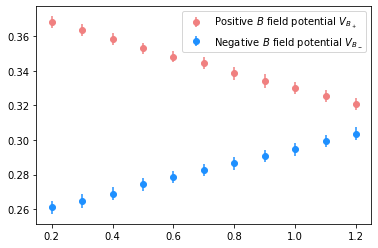

In [9]:
plt.errorbar(x=i_genBPOS, y=v_bpos, yerr=v_bpos_std, label='Positive $B$ field potential $V_{B_+}$', fmt='o', color='lightcoral')
plt.errorbar(x=i_genBNEG, y=v_bneg, yerr=v_bneg_std, label='Negative $B$ field potential $V_{B_-}$', fmt='o', color='dodgerblue')
plt.legend()

[0.26104593 0.26480938 0.26906158 0.2742913  0.2785435  0.28274682
 0.28646138 0.29071358 0.29462365 0.29931574 0.30366569]


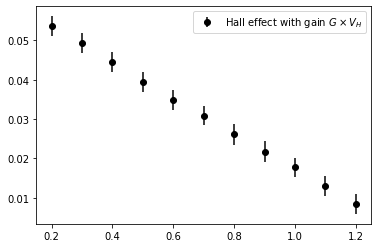

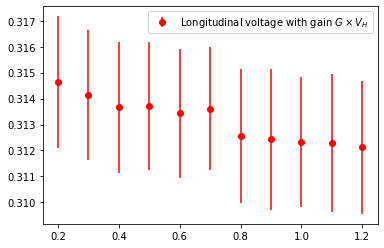

In [10]:
v_bneg_i = np.flip(v_bneg)

print(v_bneg_i)

gv_hall = (v_bpos-v_bneg_i)/2
gv_hall_std = .5*np.sqrt(v_bpos_std**2 + v_bneg_std**2)

plt.errorbar(x=i_genB, y=gv_hall, yerr=gv_hall_std, fmt='o', label='Hall effect with gain $G\\times V_H$', color='k')
plt.legend()
plt.show()

gv_long = (v_bpos+v_bneg_i)/2
gv_long_std = .5*np.sqrt(v_bpos_std**2 + v_bneg_std**2)

plt.errorbar(x=i_genB, y=gv_long, yerr=gv_long_std, fmt='o', label='Longitudinal voltage with gain $G\\times V_H$', color='r')
plt.legend()
plt.show()

In [11]:
root.gInterpreter.AddIncludePath('/usr/local/include')
root.gSystem.Load('/usr/local/lib/libErrorAnalysis')
root.gSystem.Load('/usr/local/lib/libLabTools')
root.gInterpreter.ProcessLine('''
#include<LabPlot.h>
#include<LabStat.h>
''')
            
from ROOT import set_atlas_style
set_atlas_style(28)


Applying ATLAS style settings


In [12]:
from uncertainties import unumpy

pi = np.pi

def erri(i):
    return i*0.0003 + 0.003

i_genbpos = np.array([ufloat(i, erri(i)) for i in i_genBPOS])
i_genbneg = np.array([ufloat(i, erri(i)) for i in i_genBNEG])

def b_fromi(i,
            L1=ufloat(15e-2,1e-3),
            L2=ufloat(18e-2,1e-3),
            L3=ufloat(3e-2,1e-3),
            L4=ufloat(3e-2,1e-3),
            L5=ufloat(6e-2,1e-3),
            mu_r=1e3,
            N=1.4e3,
            lt=ufloat(0.007,0.00005),
            mu0=4*pi*1e-7 # defined constant
           ):
    
    l=2*L1+L2
    
    #return 2*N*i*mu0*mu_r*L4/((l-lt)*L5) ## WRONG CALC
    return (N*i*mu0*mu_r)/(mu_r*lt+(2*L1+L2-4*L4-lt))


b_fromi(i_genbpos), b_fromi(i_genbneg)

(array([0.04785235648062788+/-0.0008016165823249065,
        0.07177853472094184+/-0.0008867634106148915,
        0.09570471296125577+/-0.00099171160215757,
        0.11963089120156974+/-0.0011108630930065156,
        0.14355706944188368+/-0.001240130668540843,
        0.1674832476821976+/-0.0013766676043288743,
        0.19140942592251153+/-0.0015185142951790523,
        0.21533560416282552+/-0.0016643136695404371,
        0.23926178240313947+/-0.0018131124263753378,
        0.2631879606434534+/-0.0019642290357378546,
        0.28711413888376736+/-0.0021171672331434157], dtype=object),
 array([0.28711413888376736+/-0.0021171672331434157,
        0.2631879606434534+/-0.0019642290357378546,
        0.23926178240313947+/-0.0018131124263753378,
        0.21533560416282552+/-0.0016643136695404371,
        0.19140942592251153+/-0.0015185142951790523,
        0.1674832476821976+/-0.0013766676043288743,
        0.14355706944188368+/-0.001240130668540843,
        0.11963089120156974+/-0.001110

In [30]:

import atlasplots as aplt

aplt.set_atlas_style()

bkg_color = root.kAzure+4

fig, (ax1, ax2) = aplt.ratio_plot(name="plot_data_bkg", figsize=(800, 900), hspace=0.04)

plot = root.TGraphErrors(11, 
                      unumpy.nominal_values(b_fromi(i_genbpos)),
                      gv_hall,
                      unumpy.std_devs(b_fromi(i_genbpos)),
                      gv_hall_std)

legend = root.TLegend(0.2,0.08,0.5,0.3)
#legend.SetHeader('E7/R3 Hall')



legend.AddEntry(plot, 'Data-V_{\iota}', 'LPE')
legend.SetFillColorAlpha(0, 0.75)
legend.SetTextSize(25)

model = root.TF1('model', '[0]+[1]*x')
model.SetLineColor(root.kRed-9)
legend.AddEntry(model, 'Model fit', 'L')

bkg = root.TGraphErrors(11,
                        unumpy.nominal_values(b_fromi(i_genbpos)),
                        (gv_long-gv_long[10])*1000,
                        unumpy.std_devs(b_fromi(i_genbpos)),
                        (gv_long_std)*1000)
bkg.SetLineColor(bkg_color)
bkg.SetMarkerColor(bkg_color)
bkg.SetFillColor(bkg_color-3)

bkg_fit = root.TF1('bkg_fit', '[2]+[0]*pow(x+[1],2)')
bkg_fit.SetLineColor(bkg_color)
bkg_fit.SetParameters(13, 0.6, 0)
bkg_fit.SetParLimits(0,11,16)
#bkg_fit.FixParameter(0,15)

bkg.SetTitle(';Magnetic field [T];V_{{\iota}}-{:.4} [mV]'.format(gv_long[10]*1000))
bkg.GetYaxis().SetTitleOffset(2)
bkg.GetXaxis().SetTitleOffset(3)

legend.AddEntry(bkg, 'Background V_{\iota}=kB^{2}', 'LPE')

plot.Fit('model')

plot.SetTitle(';Magnetic field [T];Voltage [V]')
plot.GetYaxis().SetTitleOffset(2)
ax2.set_xlabel('Magnetic field [T]')
ax2.set_ylabel('Bkg', loc='center')


ax2.cd()
bkg.Fit('bkg_fit')
bkg.Draw('AP')
bkg.GetYaxis().SetNdivisions(4)

line=root.TLine(ax1.get_xlim()[0]+0.025, 0, ax1.get_xlim()[1]-0.7, 0)
line.SetLineStyle(root.kDotted)
ax2.plot(line, linecolor=root.kBlack)

pt_like = np.linspace(start=0,stop=0.35,num=100)
v_long_eval = np.array([bkg_fit.Eval(pt)/1000 for pt in pt_like])
gv_hall_eval = np.array([model.Eval(pt) for pt in pt_like])
gv_bkg_add = gv_hall_eval+v_long_eval
gv_bkg_sub = gv_hall_eval-v_long_eval
bkg_fil = root.TGraph(2*len(pt_like))
bkg_fil.SetFillStyle(3004)
bkg_fil.SetFillColor(root.kBlack)

n = len(pt_like)
for i in range(len(pt_like)):
    bkg_fil.SetPoint(i,pt_like[i],gv_bkg_add[i])
    bkg_fil.SetPoint(n+i,pt_like[n-i-1],gv_bkg_sub[n-i-1])

ax1.cd()
plot.Draw('AP')
#bkg_fil.Draw('F')
plot.Draw('P')

#legend.AddEntry(bkg_fil, 'Data \pm Bkg. (V_{{\iota}}-{:.4})'.format(gv_long[10]), 'F')

legend.Draw()

fig.savefig('../fig/plot_vb.pdf')
fig.canvas.Draw()

p1gvh = ufloat(model.GetParameter(1), model.GetParError(1))

print(type(pt_like))

Applying ATLAS style settings
<class 'numpy.ndarray'>
 FCN=0.147715 FROM MIGRAD    STATUS=CONVERGED      47 CALLS          48 TOTAL
                     EDM=7.85651e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.24341e-02   1.85760e-03   4.01908e-07   1.97473e-02
   2  p1          -1.88436e-01   1.02537e-02   2.21851e-06   6.82864e-03
 FCN=0.0835865 FROM MIGRAD    STATUS=CONVERGED     287 CALLS         288 TOTAL
                     EDM=1.11496e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.18397e+01   3.57308e+00   9.55689e-04   4.45935e-04
   2  p1          -6.06252e-01   5.84273e+00   3.66538e-05  -1.13609e-02
   3  p2          -1.28414e+00   2.96571e+01   3.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: plot_data_bkg
Info in <TCanvas::Print>: pdf file ../fig/plot_vb.pdf has been created


In [31]:
## CONSTants

e = 1.602176634e-19        # electron charge
w = ufloat(4.5e-6,0.2e-6)  # revelator width

(-current_i10mA*gain_vh/(p1gvh*e*w)).format('.3uS')

'1.310(182)e+25'